In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams as rc

import torch
# font manager
# add font by otf file
from matplotlib import font_manager as fm
fm.fontManager.addfont("./fonts/Palatino Linotype/palatinolinotype_roman.ttf")




configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal':"asana math",
    "font.size": 18,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)
# save_root = "./figures/"

In [8]:
model_dir = "/root/tf-logs/3pits-baseline-modifiedmlp200_6-actGELU-epoch425-best_so_far/model-425.pt"

import torch
import pf_pinn as pfp
from matplotlib import gridspec
net = pfp.PFPINN(
    act=torch.nn.Tanh
)

net.to(net.device)
net.load_state_dict(torch.load(model_dir))
net

PFPINN(
  (embedding): SpatialTemporalFourierEmbedding()
  (model): PFEncodedPINN(
    (model): ModifiedMLP(
      (gate_layer_1): Linear(in_features=256, out_features=200, bias=True)
      (gate_layer_2): Linear(in_features=256, out_features=200, bias=True)
      (hidden_layers): ModuleList(
        (0): Linear(in_features=256, out_features=200, bias=True)
        (1): Linear(in_features=200, out_features=200, bias=True)
        (2): Linear(in_features=200, out_features=200, bias=True)
        (3): Linear(in_features=200, out_features=200, bias=True)
        (4): Linear(in_features=200, out_features=200, bias=True)
        (5): Linear(in_features=200, out_features=200, bias=True)
      )
      (out_layer): Linear(in_features=200, out_features=2, bias=True)
      (act): GELU()
    )
  )
)

/tmp/ipykernel_54153/3865986997.py:57: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(error, cax=ax_bar)


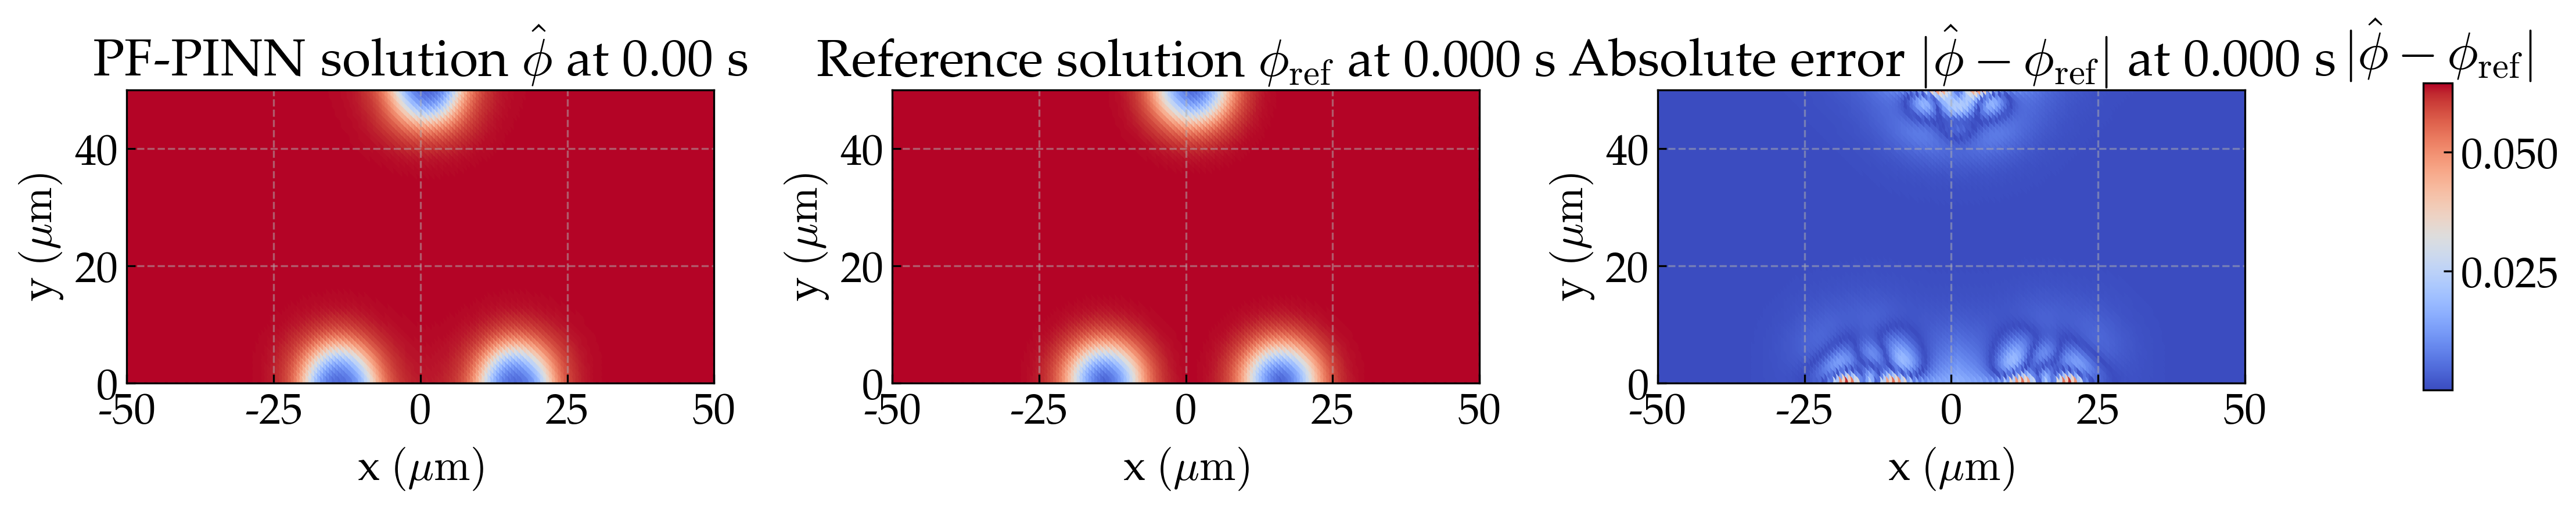

In [9]:
tic = 0.0

mesh_points = np.load("./data/2d-3pits/mesh_points.npy") * 1e4
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])
fig = plt.figure(figsize=(15, 3), dpi=300)
tic_tensor = torch.ones(mesh_points.shape[0], 1).view(-1, 1) * 0.0 * 1e-1
mesh_tensor = torch.from_numpy(mesh_points).float()
geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
with torch.no_grad():
    sol = net(geotime).cpu().detach().numpy()
    
ax = fig.add_subplot(gs[0])
ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=sol[:, 0], cmap='coolwarm', vmin=0, vmax=1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.set(
    xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
    xlim=(-0.5, 0.5), ylim=(0, 0.5),
    title=r"PF-PINN solution $\hat\phi$" + " at "+ f"{tic:.2f} s"
)

truth = np.load("./data/2d-3pits/sol-" + f"{tic:.3f}.npy")
# if np.abs(tic) < 1e-5:
#     truth_phi = 1 - (1 - np.tanh(np.sqrt(OMEGA_PHI) /
#                                  np.sqrt(2 * ALPHA_PHI) * \
#                                 ( np.sqrt((np.abs(mesh_points[:, 0]) - 0.15)**2 + mesh_points[:, 1]**2) -0.05) / 1e4)) / 2
#     truth = np.vstack([truth_phi, truth_phi]).T

diff = np.abs(truth[:, 0] - sol[:, 0])


ax = fig.add_subplot(gs[1])
ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm', vmin=0, vmax=1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.set(
    xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
    xlim=(-0.5, 0.5), ylim=(0, 0.5),
    title=r"Reference solution $\phi_{\mathrm{ref}}$" + " at "+ f"{tic:.3f} s" 
)

ax = fig.add_subplot(gs[2])
error = ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=diff, cmap='coolwarm')
# ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm', vmin=0, vmax=1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax.set(
    xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
    xlim=(-0.5, 0.5), ylim=(0, 0.5),
    title=r"Absolute error $|\hat\phi - \phi_{\mathrm{ref}}|$" + " at "+ f"{tic:.3f} s" 
)

ax_bar = fig.add_subplot(gs[3])
cbar = fig.colorbar(error, cax=ax_bar)
ax_bar.set_title(r"$\mathrm{|\hat\phi - \phi_{\mathrm{ref}}|}$", loc='center')
plt.tight_layout()
# plt.savefig("out.jpg", dpi=300, bbox_inches='tight')

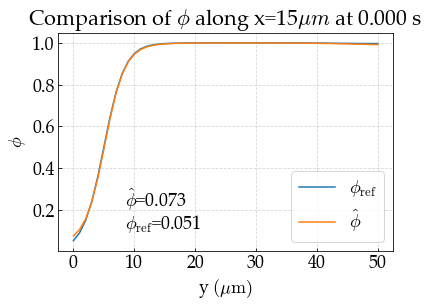

In [10]:
idx_yaxis = np.where(np.abs(mesh_points[:, 0]-0.15) < 1e-5)[0]
y_axis = mesh_points[idx_yaxis]
y_axis_truth = truth[idx_yaxis]
y_axis_sol = sol[idx_yaxis]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(y_axis[:, 1], y_axis_truth[:, 0], label=r"$\phi_{\mathrm{ref}}$")
ax.plot(y_axis[:, 1], y_axis_sol[:, 0], label=r"$\hat\phi$")
ax.set(
    xlabel="y " + r"$\mathrm{(\mu m)}$", ylabel=r"$\phi$",
    title=r"Comparison of $\phi$ along x=15$\mu m$ at " + f"{tic:.3f} s"
)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))

ax.text(0.2, 0.1, "$\phi_{\mathrm{ref}}$" + "=" + f"{y_axis_truth[-1, 0]:.3f}", transform=ax.transAxes)
ax.text(0.2, 0.2, "$\hat\phi$" + "=" + f"{y_axis_sol[-1, 0]:.3f}", transform=ax.transAxes)


ax.legend()

# ax_inset = fig.add_axes([0.4, 0.3, 0.25, 0.25])
# ax_inset.plot(y_axis[:, 1], y_axis_truth[:, 0], label=r"$\phi_{\mathrm{ref}}$")
# ax_inset.plot(y_axis[:, 1], y_axis_sol[:, 0], label=r"$\hat\phi$")
# ax_inset.set(
#     xlim=(-0.02, 0.05), ylim=(0., 0.3),
#     xticks=[],
#     yticks=[]
# )
# plt.savefig("out-y.jpg", dpi=300, bbox_inches='tight')


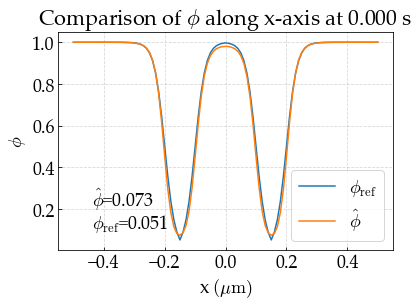

In [11]:
idx_xaxis = np.where(np.abs(mesh_points[:, 1]) < 1e-5)[0]
x_axis = mesh_points[idx_xaxis]
x_axis_truth = truth[idx_xaxis]
x_axis_sol = sol[idx_xaxis]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_axis[:, 0], x_axis_truth[:, 0], label=r"$\phi_{\mathrm{ref}}$")
ax.plot(x_axis[:, 0], x_axis_sol[:, 0], label=r"$\hat\phi$")
ax.set(
    xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel=r"$\phi$",
    title=r"Comparison of $\phi$ along x-axis at " + f"{tic:.3f} s"
)

ax.text(0.1, 0.1, "$\phi_{\mathrm{ref}}$" + "=" + f"{x_axis_truth[:, 0].min():.3f}", transform=ax.transAxes)
ax.text(0.1, 0.2, "$\hat\phi$" + "=" + f"{x_axis_sol[:, 0].min():.3f}", transform=ax.transAxes)
ax.legend(loc="lower right")
# plt.savefig("out-x.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_54153/1053779357.py:63: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax.collections[0], cax=ax_bar)


0.002484691907003985


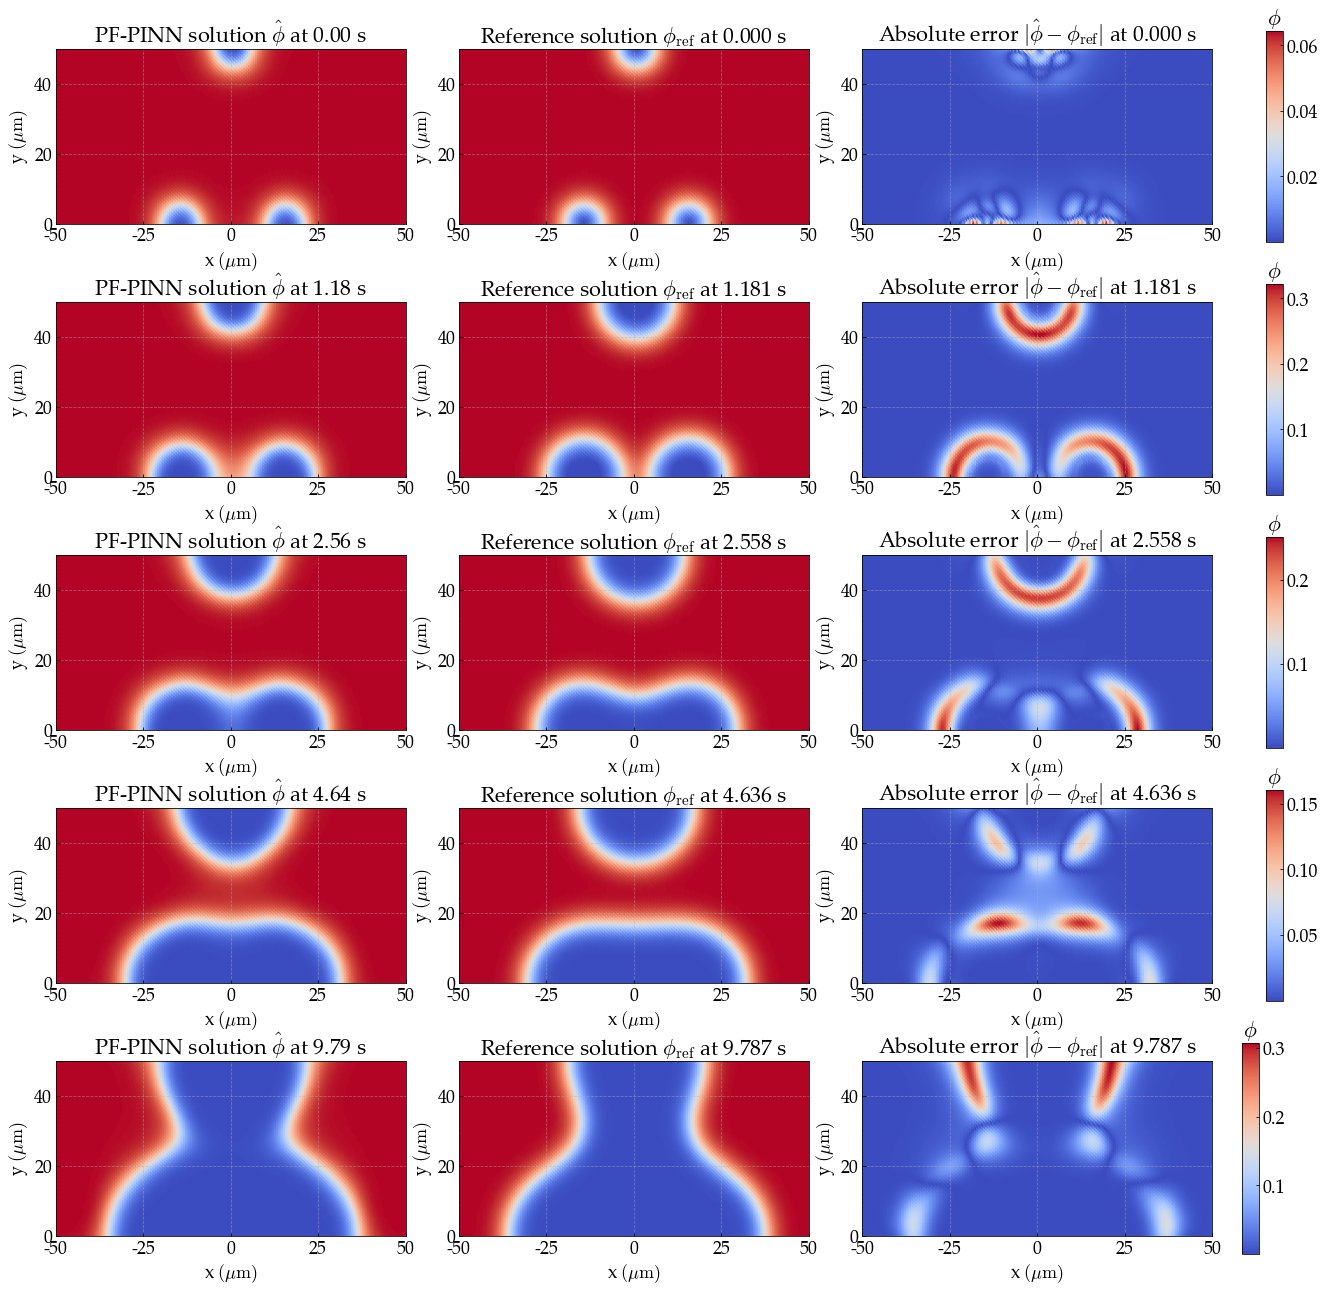

In [17]:
ts = [0.000, 1.181, 2.558, 4.636, 9.787]
# ts = [ 49.15]
mesh_points = np.load("./data/2d-3pits/mesh_points.npy") * 1e4
# mesh_points = mesh_points[mesh_points[:, 1] < 0.5 & np.abs()]
mse = 0

fig = plt.figure(figsize=(22, 4.5*len(ts)))
gs = gridspec.GridSpec(len(ts), 4, width_ratios=[1, 1, 1, 0.05])
for idx, tic in enumerate(ts):
    
    
    tic_tensor = torch.ones(mesh_points.shape[0], 1).view(-1, 1) * tic * 1e-1
    mesh_tensor = torch.from_numpy(mesh_points).float()
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net(geotime).cpu().detach().numpy()

    ax = fig.add_subplot(gs[idx, 0])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=sol[:, 0], cmap='coolwarm',)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"PF-PINN solution $\hat\phi$" + " at "+ f"{tic:.2f} s"
    )
    
    truth = np.load("./data/2d-3pits/sol-" + f"{tic:.3f}.npy")
    # if np.abs(tic) < 1e-5:
    #     truth_phi = 1 - (1 - np.tanh(np.sqrt(OMEGA_PHI) /
    #                                  np.sqrt(2 * ALPHA_PHI) * \
    #                                 ( np.sqrt((np.abs(mesh_points[:, 0]) - 0.15)**2 + mesh_points[:, 1]**2) -0.05) / 1e4)) / 2
    #     truth = np.vstack([truth_phi, truth_phi]).T
    
    diff = np.abs(truth[:, 0] - sol[:, 0])
    
    
    ax = fig.add_subplot(gs[idx, 1])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm',)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"Reference solution $\phi_{\mathrm{ref}}$" + " at "+ f"{tic:.3f} s" 
    )
    
    ax = fig.add_subplot(gs[idx, 2])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=diff, cmap='coolwarm',)
    # ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm', vmin=0, vmax=1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"Absolute error $|\hat\phi - \phi_{\mathrm{ref}}|$" + " at "+ f"{tic:.3f} s" 
    )
    mse += np.mean(diff**2)
    ax_bar = fig.add_subplot(gs[idx, 3])
    fig.colorbar(ax.collections[0], cax=ax_bar)
    ax_bar.set_title(r'$\phi$', loc='center')
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    pos = ax_bar.get_position()
    ax_bar.set_position([pos.x0 - 0.015, pos.y0, pos.width, pos.height])
    # plt.savefig(save_root + f"2d-diffusion-2pits-baseline-fields-{idx}.png", dpi=300, bbox_inches='tight')
mse /= len(ts)
print(mse)
# plt.savefig("out.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_54153/1223178378.py:67: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(ax.collections[0], cax=ax_bar, orientation='vertical',)


0.002484691907003985


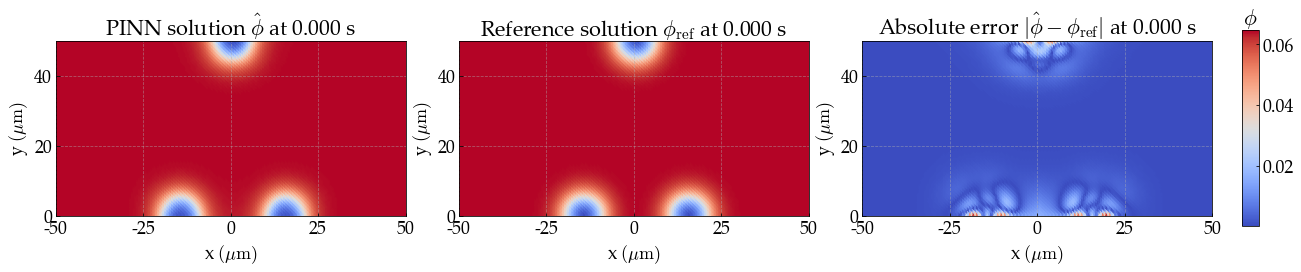

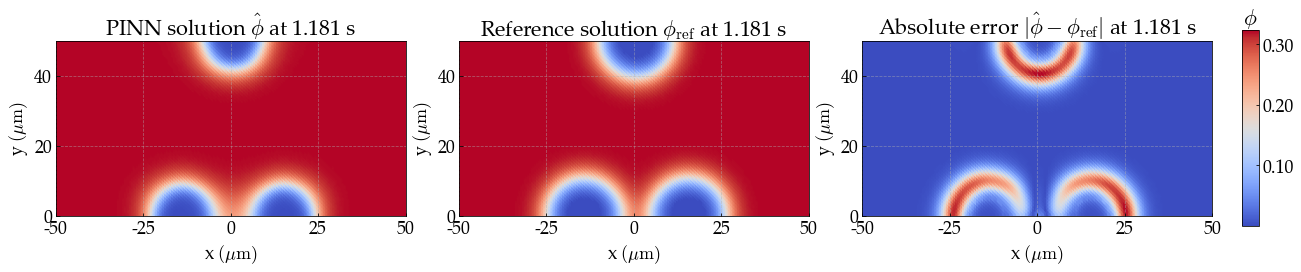

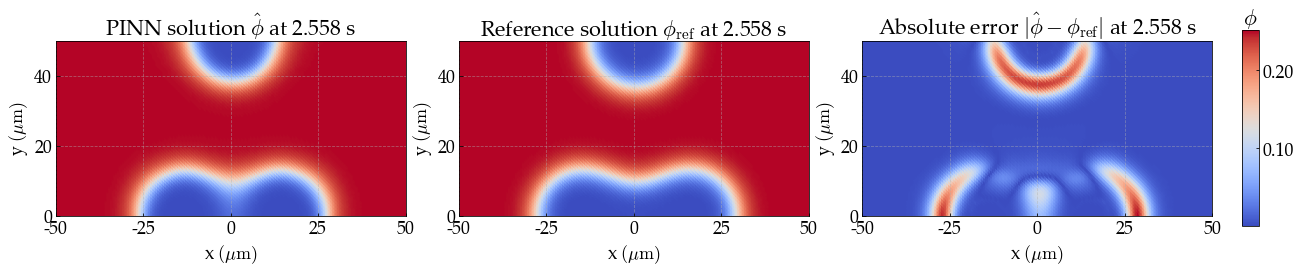

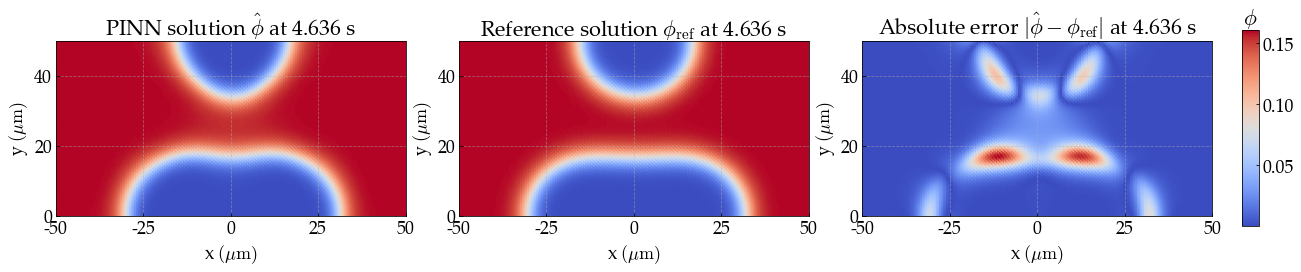

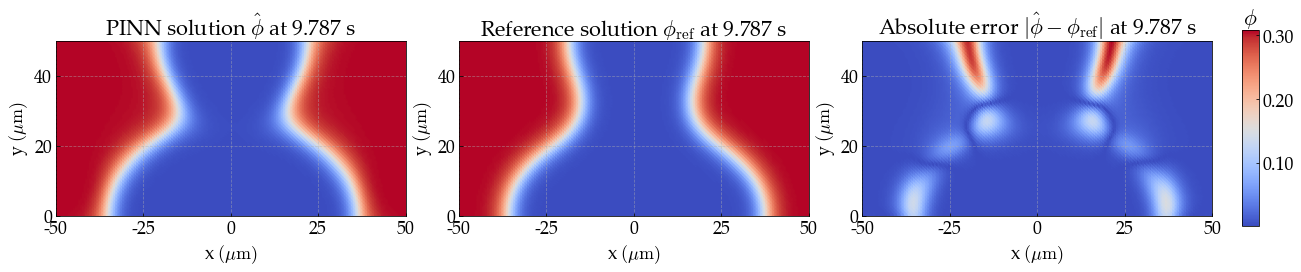

In [33]:
ts = [0.000, 1.181, 2.558, 4.636, 9.787]
# ts = [ 49.15]
mesh_points = np.load("./data/2d-3pits/mesh_points.npy") * 1e4
# mesh_points = mesh_points[mesh_points[:, 1] < 0.5 & np.abs()]
mse = 0

# fig = plt.figure(figsize=(22, 4.5*len(ts)))
# gs = gridspec.GridSpec(len(ts), 4, width_ratios=[1, 1, 1, 0.05])
for idx, tic in enumerate(ts):
    
    fig = plt.figure(figsize=(22, 4.5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])
    tic_tensor = torch.ones(mesh_points.shape[0], 1).view(-1, 1) * tic * 1e-1
    mesh_tensor = torch.from_numpy(mesh_points).float()
    geotime = torch.cat([mesh_tensor, tic_tensor], dim=1).to(net.device)
    with torch.no_grad():
        sol = net(geotime).cpu().detach().numpy()

    ax = fig.add_subplot(gs[0])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=sol[:, 0], cmap='coolwarm',)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"PINN solution $\hat\phi$" + " at "+ f"{tic:.3f} s"
    )
    
    truth = np.load("./data/2d-3pits/sol-" + f"{tic:.3f}.npy")
    # if np.abs(tic) < 1e-5:
    #     truth_phi = 1 - (1 - np.tanh(np.sqrt(OMEGA_PHI) /
    #                                  np.sqrt(2 * ALPHA_PHI) * \
    #                                 ( np.sqrt((np.abs(mesh_points[:, 0]) - 0.15)**2 + mesh_points[:, 1]**2) -0.05) / 1e4)) / 2
    #     truth = np.vstack([truth_phi, truth_phi]).T
    
    diff = np.abs(truth[:, 0] - sol[:, 0])
    
    
    ax = fig.add_subplot(gs[1])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm',)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"Reference solution $\phi_{\mathrm{ref}}$" + " at "+ f"{tic:.3f} s" 
    )
    
    ax = fig.add_subplot(gs[2])
    ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=diff, cmap='coolwarm',)
    # ax.scatter(mesh_points[:, 0], mesh_points[:, 1], c=truth[:, 0], cmap='coolwarm', vmin=0, vmax=1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x*1e2:.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.25))
    ax.set(
        xlabel="x " + r"$\mathrm{(\mu m)}$", ylabel="y " + r"$\mathrm{(\mu m)}$", aspect='equal',
        xlim=(-0.5, 0.5), ylim=(0, 0.5),
        title=r"Absolute error $|\hat\phi - \phi_{\mathrm{ref}}|$" + " at "+ f"{tic:.3f} s" 
    )
    mse += np.mean(diff**2)
    
    ax_bar = fig.add_subplot(gs[3])
    
    # colorbar height: 0.8
    fig.colorbar(ax.collections[0], cax=ax_bar, orientation='vertical',)
    ax_bar.set_title(r'$\phi$', loc='center')
    ax_bar.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2f}'))
    # plt.subplots_adjust(wspace=0.2, hspace=0.2)
    pos = ax_bar.get_position()
    ax_bar.set_position([pos.x0 - 0.015, pos.y0+pos.height*0.1, pos.width, pos.height*0.8])
    plt.savefig("./figures/2d-3pits-phi-fields-" + f"{idx}.png", dpi=300, bbox_inches='tight')
mse /= len(ts)
print(mse)
